
# Project 3: Classifying a Reddit post - Classification


--- 
# Part 3

### Model Comparison, Findings, Conclusion

---

#### Let's compare the models.  
We have looked at KNN and SVC in detail. Lets look at all the 4 models we have created. 
We created separate files for each of the models which contain all the classification metrics. So all we have to do is merge the files and we can do aggregate analysis across all our models. 


In [1]:
# Imports:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, plot_roc_curve, roc_auc_score, precision_score, f1_score, recall_score, roc_curve

import pickle
import time
import seaborn as sns


#### Function to read the metrics data files for each of our models, drop the Unnamed column, merge and return the combined dataframe, as well as each of the individual dataframes in case we need to perform additional analysis per model


In [2]:
# Fuction to merge results data files and return the combined dataframe as well as all the individual model dataframes

def prepare_df(file1, file2, file3, file4 ):
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    df3 = pd.read_csv(file3)
    df4 = pd.read_csv(file4)

#    print( file1, file2, file3, file4)

    df1.drop( columns="Unnamed: 0", inplace=True)     
    df2.drop( columns="Unnamed: 0", inplace=True)
    df3.drop( columns="Unnamed: 0", inplace=True)
    df4.drop( columns="Unnamed: 0", inplace=True)

    
    print( f"Shape df1: {df1.shape}, df2: {df2.shape}, df3: {df3.shape}, df4: {df4.shape}")

    # combine into merged dataframe
    comparison_df = df1.append(df2, ignore_index=True)
    comparison_df = comparison_df.append(df3, ignore_index=True)
    comparison_df = comparison_df.append(df4, ignore_index=True)

    print( f"Shape combined: {comparison_df.shape}")

    return [comparison_df, df1, df2, df3, df4]

In [3]:
# Call the function 
comparison_df, df1, df2, df3, df4  = prepare_df("../data/rf_results_df.csv", 
                          "../data/svc_results_df.csv", "../data/knn_results_df_neighbors.csv", "../data/et_results_df.csv")


Shape df1: (9, 18), df2: (9, 18), df3: (9, 20), df4: (9, 18)
Shape combined: (36, 20)


#### Note that KNN has many outliers (maybe we need to do additional hyper-parameter tuning). So added the columns for number of neighbors and Weights so we can look at them in detail if we want


In [4]:
# Remove some outliers for better graphing
var_df = comparison_df[comparison_df['Variance of Test vs Training Score']<5] # dropped those that are too high

var_df = var_df[var_df["Specificity"]>0.33]  # dropped 2 outliers
var_df["Specificity"] = round(var_df["Specificity"],2) # for display in graph, use just 2 decimal places

#var_df.to_csv('../data/combined_result.csv')
var_df # see our nice dataframe

,Reddit Text Type,Stop Word Type,Baseline Score,Training Score,Test Score,Variance of Test vs Training Score,TN,FP,FN,TP,Accuracy,Sensitivity,Specificity,Precision,F1 Score,ROC AUC Score,Best Score,Model,Neighbors,Weights
0,title,english,0.704161,0.873649,0.856241,1.992555,567,464,37,2417,0.856241,0.984923,0.55,0.838945,0.906092,0.877836,0.852511,RandomForest,NaN,NaN
1,title,Top 100,0.704161,0.846868,0.835007,1.400497,481,550,25,2429,0.835007,0.989813,0.47,0.815374,0.894165,0.836886,0.835868,RandomForest,NaN,NaN
2,title,Top 1000,0.704161,0.817217,0.812339,0.596910,387,644,10,2444,0.812339,0.995925,0.38,0.791451,0.881992,0.759482,0.808226,RandomForest,NaN,NaN
5,selftext,Top 1000,0.704161,0.845146,0.824677,2.421910,460,571,40,2414,0.824677,0.983700,0.45,0.808710,0.887663,0.844507,0.817886,RandomForest,NaN,NaN
7,title_selftext,Top 100,0.704161,0.957437,0.909613,4.995005,801,230,85,2369,0.909613,0.965363,0.78,0.911504,0.937661,0.944254,0.909613,RandomForest,NaN,NaN
8,title_selftext,Top 1000,0.704161,0.882066,0.865710,1.854262,586,445,23,2431,0.865710,0.990628,0.57,0.845271,0.912195,0.892987,0.857484,RandomForest,NaN,NaN
9,title,english,0.704161,0.866858,0.857389,1.092354,591,440,57,2397,0.857389,0.976773,0.57,0.844907,0.906067,0.869383,0.858250,SVC,NaN,NaN
10,title,Top 100,0.704161,0.852798,0.840459,1.446837,517,514,42,2412,0.840459,0.982885,0.50,0.824334,0.896654,0.838206,0.841416,SVC,NaN,NaN
11,title,Top 1000,0.704161,0.828503,0.816069,1.500808,429,602,39,2415,0.816069,0.984108,0.42,0.800464,0.882837,0.782476,0.812434,SVC,NaN,NaN
12,selftext,english,0.704161,0.909039,0.884648,2.683081,757,274,128,2326,0.884648,0.947840,0.73,0.894615,0.920459,0.926414,0.891631,SVC,NaN,NaN


#### **Interpretation**: We now have a nice dataframe with all the results with categories for the Reddit Text Type and the Stop Word Type. 

Rather than comparing the individual Training and Test scores, we created a column that has their percent difference:  
(Training Score-Test Score)/Training Score*100. 
We can now sort by this. Many of our Variance scores are low with the lowest being 0.22% i.e. 0.0022. This model has really low variance and we expect this to perform very well on new unseen data. Pretty much all the models with the variance being < 2% will do well. The absolute number of the Training Score (in these cases similar to the Test Score) indicates the accuracy of our model. 

**The Accuracy, Sensitivity and Precision, F1 and ROC AUC scores all are pretty good when our Training Score is high. However, the Specificity varies considerably. Hence we will focus on the Specificity in relation to the Variance to rate our models.**



#### Visualizations
Lets view our results across models visually.  

**Training Score** or Accuracy

<Figure size 1152x432 with 0 Axes>

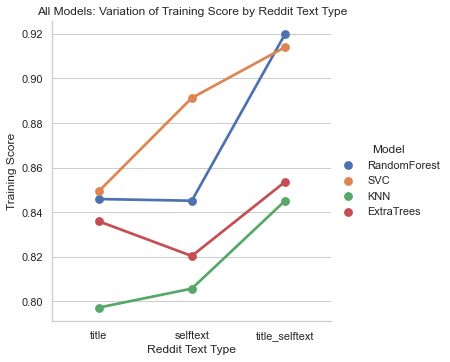

In [13]:
plt.figure(figsize=(16,6));

sns.catplot(data = var_df, kind = 'point', x = 'Reddit Text Type', y = 'Training Score', hue = 'Model', ci=None).set( 
    title = "All Models: Variation of Training Score by Reddit Text Type");
plt.savefig("../images/model_comparision.png")


#### **Interpretation**: 
This shows the Training Score by Reddit Text Type across all models. 
As we can see, each classification model performs better as it gets more data from title to selftext to both title and selftext. 

We also see that Random Forest and SVC do really well with Training score above 0.9 showing high accuracy. 

However, we cannot use the Training Score in isolation since a model may be overfit and hence we need to look at the Test Score too. We will look at the Variance of Test vs Training Score for this comparison. 



#### Now, lets look at the Training Score vs Test Score - if they are too far apart, the model is overfit and high variance

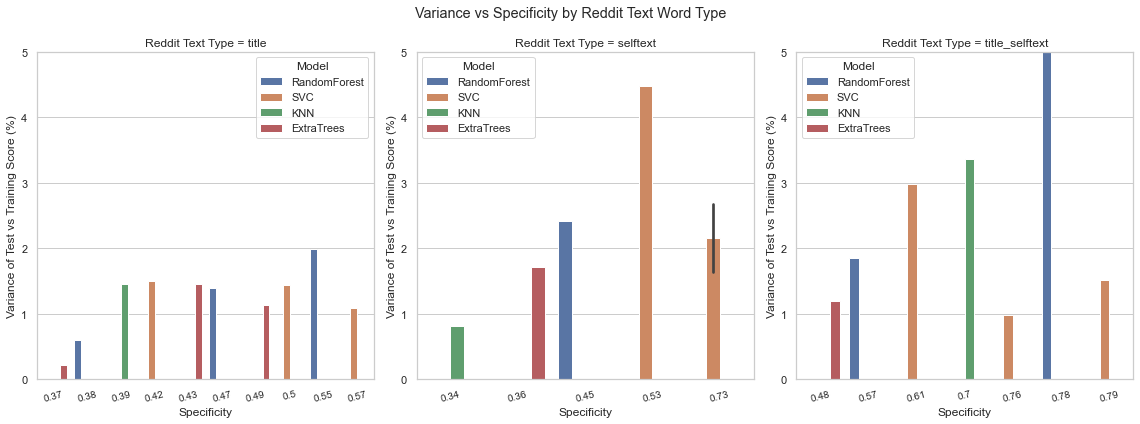

In [12]:
# Lets compare by Variance vs Specificity by Reddit Text Word Type

sns.set(style="whitegrid")
plt.figure(figsize=(16,6))

for ax_num, type in zip(range(1,5), ['title', 'selftext', 'title_selftext']):
    plt.subplot(1,3,ax_num)
    sns.barplot(x='Specificity', y='Variance of Test vs Training Score', hue='Model',
                                    data=var_df[var_df['Reddit Text Type'] == type])
    plt.xticks(rotation=15, fontsize=10)
    plt.title(f"Reddit Text Type = {type}")
    plt.ylim( 0, 5) # ensure all are on same axes for easier visual comparison
    plt.ylabel("Variance of Test vs Training Score (%)")

plt.suptitle("Variance vs Specificity by Reddit Text Word Type");
plt.tight_layout()

plt.savefig("../images/variance_vs_specificity_all_models.png")

#### **Interpretation**: 

This is our main graphic and compares our models by the 2 main metrics that matter for us. 
1. We want low variance and high Specificity. We see graph #3 (with title_selftext, rightmost) has the best results. SVC shows high Specificity (0.76 and 0.79) with low variance of 1%. Random Forest and KNN also do quite well, though not as well as SVC. 
Any of the three models on the rightmost will work well. 
2. In the first graph, the variance is low (all below 2% but the Specificity is very low. As we have seen previously too, training the model on more data helps improve performance. 
3. SVC performs well with just the selftext too, though not as well as with title_selftext. 



#### Ideally we want the highest Training Score (and closest Test Score) and highest Specificity

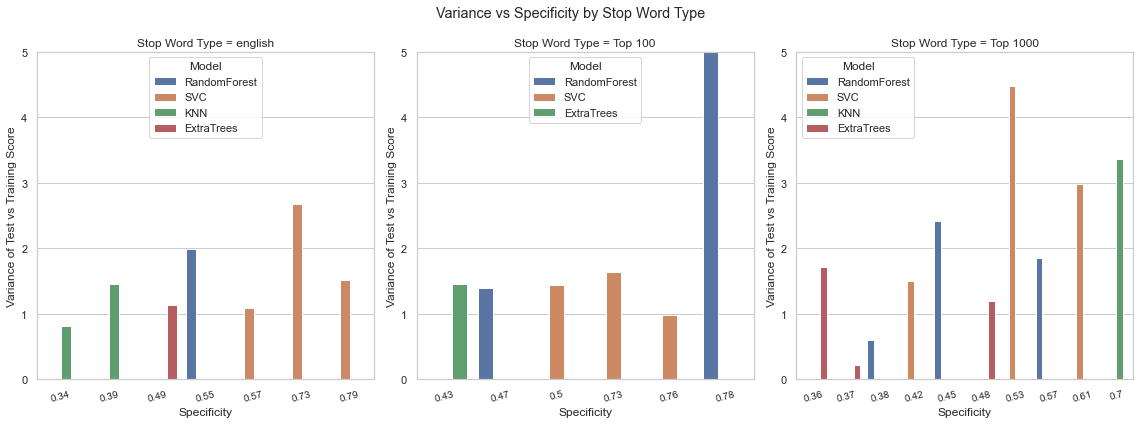

In [7]:
# Plot Variance vs Specificity by Stop Word Type
sns.set(style="whitegrid")


plt.figure(figsize=(16,6));

for ax_num, type in zip(range(1,5), ['english', 'Top 100', 'Top 1000']):
    plt.subplot(1,3,ax_num)
    sns.barplot(x='Specificity', y='Variance of Test vs Training Score', hue='Model',
                                    data=var_df[var_df['Stop Word Type'] == type])
    plt.xticks(rotation=15, fontsize=10)
    plt.ylim( 0, 5) # ensire all are on same axes for easier visual comparison

    plt.title(f"Stop Word Type = {type}")
plt.suptitle("Variance vs Specificity by Stop Word Type");

plt.tight_layout()



#### **Interpretation**: 

This is similar to the previous graph except we are looking by Stop Word Type. 

Again, we want low variance and high Specificity. We see graph #2 (Top 100, middle graph) has the best results. SVC shows high Specificity (0.76 and 0.73) with low variance of 1%. Random Forest has a higher Specificity though it has higher variance too. 



In [8]:
#### Catplot Box graph of Reddit Text Tupe vs Specificity, across all models

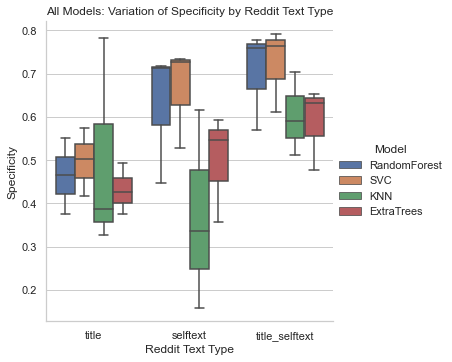

In [9]:
sns.catplot(data = comparison_df, kind = 'box', x = 'Reddit Text Type', y = 'Specificity', hue = 'Model').set( 
    title = "All Models: Variation of Specificity by Reddit Text Type");



#### **Interpretation**: 
This shows the range of possible values in the boxplot. KNN has the biggest variation with the median Specificity being 0.35 and the low around 0.25
Again, the best seems to be SVC. 


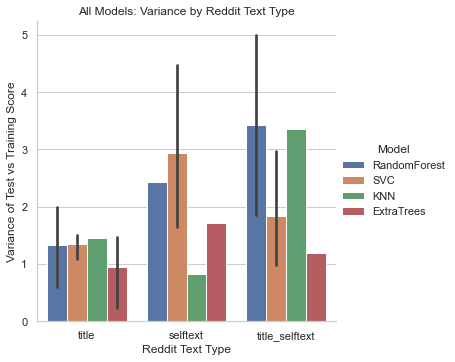

In [10]:
sns.catplot(data = var_df, kind = 'bar', x = 'Reddit Text Type', y = 'Variance of Test vs Training Score', hue = 'Model').set( 
    title = "All Models: Variance by Reddit Text Type");



#### **Interpretation**: 
Variance is low for title and higher for title_selftext (well within acceptable range), but the overall accuracy is much higher with title_selftext. 


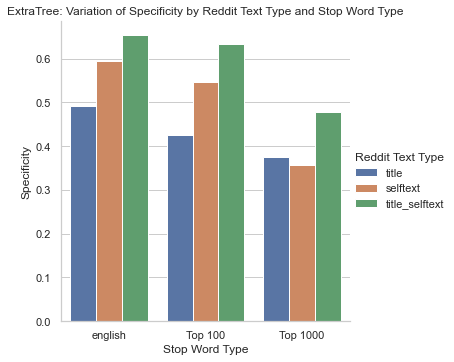

In [11]:
# ExtraTrees Classifier
sns.catplot(data = df4, kind = 'bar', x = 'Stop Word Type', y = 'Specificity', hue = 'Reddit Text Type').set(
    title = "ExtraTree: Variation of Specificity by Reddit Text Type and Stop Word Type");



#### **Interpretation**: 
Extra Trees Classifier doesn't do very well on Specificity

## Conclusions<a class="anchor" id="Conclusions"></a>

- Pre-processing of data and EDA is super important. More than spending time on tuning model with hyper-parameters with GridSearch
- Accuracy by itself is not critical for all use cases. Pick your metric!
- Random Forest max_depth of the Decision Tree is 70, still test score is fine and the model is not overfit at all, due to pre-processing of data
- SVC: predict_proba doesn’t match with prediction
- Evaluation metrics may not be the final decider in choosing the best model! 



## Next Steps<a class="anchor" id="Next-Steps"></a>




- With a high accuracy of 92%, and low variance, the model is good to go! 
- Still room for improvement: 
    - Lemmatize, stemming
    - Top 300 or Top 500 - hyper-param tuning for stop words
    - KNN more tuning 
    - Extend from binary classification to multi-class
    - Can maybe try more balanced classes: currently baseline is 70%, could maybe try oversampling majority and under-sampling minority class
    - Clean up warnings: 
        - UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['running'] not in stop_words. 



## Bibliography <a class="anchor" id="Bibliography"></a>


+ Adding words to scikit-learn's CountVectorizer's stop list - Stack Overflow   
Source: https://stackoverflow.com/questions/63061046/how-to-change-the-number-or-rows-and-columns-in-my-seaborn-catplot

+ How to change the number or rows and columns in my seaborn catplot - Stack Overflow  
Source: https://stackoverflow.com/questions/63061046/how-to-change-the-number-or-rows-and-columns-in-my-seaborn-catplot

+ Plot ROC curve  
Source: https://github.com/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb

+ SVC predict_proba doesn’t match with predictions  
Source: https://scikit-learn.org/stable/modules/svm.html#scores-probabilities



#### End of notebook